<a href="https://colab.research.google.com/github/chasubeen/ML_lab/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. Import libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **1. Preparing data**

In [3]:
### Preprocessing

transform = transforms.Compose([
    transforms.ToTensor(), # tensor로 변환
    transforms.Normalize((0.1307,), (0.3081,)) # 정규화
    ])

train_dataset = datasets.MNIST(
    root = "../data", train = True, transform = transform, download = True)

test_dataset = datasets.MNIST(
    root = "../data", train = False, transform = transform, download = True)

In [4]:
### Define dataloaders

train_loader = DataLoader(
    train_dataset, batch_size = 128, shuffle = True, num_workers = 4)

test_loader = DataLoader(
    test_dataset, batch_size = 32, shuffle = False, num_workers = 4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# **2. Network**
- Encoder: 데이터셋을 저차원으로 압축하는 네트워크
  - 784→256→256→64
- Decoder: 압축된 데이터셋을 다시 원래의 차원으로 복원하는 네트워크
  - (64) → 256→256→784

In [5]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    # Encoder
    self.encoder = nn.Sequential(
      nn.Linear(784, 256),
      nn.ReLU(),

      nn.Linear(256, 256),
      nn.ReLU(),

      nn.Linear(256, 64),
      nn.ReLU()
    )

    # Decoder
    self.decoder = nn.Sequential(
      nn.Linear(64, 256),
      nn.ReLU(),

      nn.Linear(256, 256),
      nn.ReLU(),

      nn.Linear(256, 784),

      nn.Sigmoid()  # 출력 값(pixel 화소 값)이 0 ~ 1이 되도록
    )

  def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

# **3. Training**

In [10]:
model = AutoEncoder()
loss_fn = nn.MSELoss() # Entropy 관점으로 본다면 BCELoss도 가능할 것임
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-05)

In [11]:
num_epochs = 30
# 손실 값을 저장하기 위한 리스트
train_losses = []

In [12]:
### Training loop

for epoch in range(num_epochs):
  model.train()
  epoch_loss = 0

  for data in train_loader:
    img, _ = data
    img = img.view(img.size(0), -1)  # 이미지를 1차원으로 펼치기

    # Forward pass
    output = model(img)
    loss = loss_fn(output, img)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  epoch_loss /= len(train_loader)
  train_losses.append(epoch_loss)

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/30], Loss: 0.7704
Epoch [2/30], Loss: 0.6214
Epoch [3/30], Loss: 0.5795
Epoch [4/30], Loss: 0.5591
Epoch [5/30], Loss: 0.5450
Epoch [6/30], Loss: 0.5351
Epoch [7/30], Loss: 0.5277
Epoch [8/30], Loss: 0.5220
Epoch [9/30], Loss: 0.5182
Epoch [10/30], Loss: 0.5148
Epoch [11/30], Loss: 0.5117
Epoch [12/30], Loss: 0.5089
Epoch [13/30], Loss: 0.5067
Epoch [14/30], Loss: 0.5043
Epoch [15/30], Loss: 0.5028
Epoch [16/30], Loss: 0.5015
Epoch [17/30], Loss: 0.5005
Epoch [18/30], Loss: 0.4995
Epoch [19/30], Loss: 0.4985
Epoch [20/30], Loss: 0.4977
Epoch [21/30], Loss: 0.4969
Epoch [22/30], Loss: 0.4963
Epoch [23/30], Loss: 0.4958
Epoch [24/30], Loss: 0.4951
Epoch [25/30], Loss: 0.4943
Epoch [26/30], Loss: 0.4937
Epoch [27/30], Loss: 0.4931
Epoch [28/30], Loss: 0.4928
Epoch [29/30], Loss: 0.4924
Epoch [30/30], Loss: 0.4917


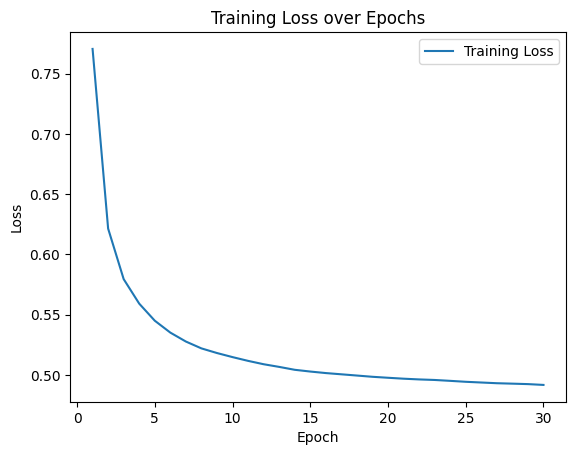

In [13]:
### 시각화

import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# **4. Testing**

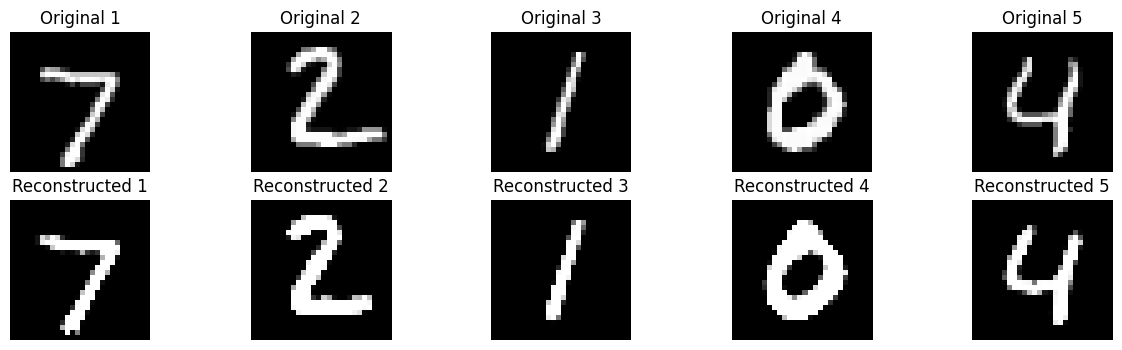

In [23]:
model.eval()

with torch.no_grad():
  for data in test_loader:
    img, _ = data
    img = img.view(img.size(0), -1)

    # Forward pass
    output = model(img)

    # 샘플로 5개의 이미지를 시각화합니다
    num_samples = 5
    fig, axes = plt.subplots(2, num_samples, figsize = (15, 4))

    for i in range(num_samples):
      original_img = img[i].view(28, 28).cpu().numpy()
      reconstructed_img = output[i].view(28, 28).cpu().numpy()

      # 원본 이미지를 첫 번째 행에 표시
      axes[0, i].imshow(original_img, cmap='gray')
      axes[0, i].set_title(f"Original {i+1}")
      axes[0, i].axis('off')

      # 재구성된 이미지를 두 번째 행에 표시
      axes[1, i].imshow(reconstructed_img, cmap='gray')
      axes[1, i].set_title(f"Reconstructed {i+1}")
      axes[1, i].axis('off')

    plt.show()

    # 첫 번째 배치만 시각화 후 break
    break